# Sprint11課題 深層学習スクラッチディープニューラルネットワーク

In [57]:
#データセットの用意
from keras.datasets import mnist
import numpy as np
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [58]:
#reshape
test = X_train[0]
print(test.shape)
test = test.reshape(-1, 1)
print(test.shape)

(28, 28)
(784, 1)


In [59]:
#reshape
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])

In [60]:
#前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())
print(X_train.min())

1.0
0.0


In [61]:
#split into train, val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape) 

(48000, 784)
(12000, 784)


## 【問題1】全結合層のクラス化
コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [179]:
import numpy as np
class FullyConnectedLayer:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W, self.B  = initializer.coef(n_nodes1, n_nodes2)
        self.pre_Z = None
        
        self.dA = None
        self.dB = None
        self.dW = None
        self.d_pre_Z = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.pre_Z = np.copy(X)
        A = self.pre_Z @ self.W + self.B
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA
        self.d_pre_Z = (dA @ self.W.T)
        
        self.dW = np.mean(self.pre_Z.T, axis=1).reshape(-1, 1) @  dA
        
        # 更新
        self = self.optimizer.update(self)
        
        
        return self.d_pre_Z


## 【問題2】初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [123]:
import numpy as np
class SimpleInitializer:
        """
        ガウス分布によるシンプルな初期化
        Parameters
        ----------
        sigma : float
          ガウス分布の標準偏差
        """
        def __init__(self, sigma):
                self.sigma = sigma
                
        def coef(self, n_nodes1, n_nodes2):
                """
                重みの初期化
                Parameters
                ----------
                n_nodes1 : int
                  前の層のノード数
                n_nodes2 : int
                  後の層のノード数

                Returns
                ----------
                W :
                """
                
                W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
                B = self.sigma * np.random.randn(1, n_nodes2)
                return W, B


class XavierInitializer():
        def __init__(self):
                self.sigma = None
        def coef(self, n_nodes1,  n_nodes2):
                self.sigma = 1/np.power(n_nodes1, 1/2)
                W = np.random.normal(loc=0.0, scale=self.sigma, size=(n_nodes1,  n_nodes2))
                B = np.random.normal(loc=0.0, scale=self.sigma, size=(1,  n_nodes2))
                return W, B
                
        

## 【問題3】最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [124]:
class StochasticGradientDescent():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB
        return layer

## 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。

In [171]:
import numpy as np

class Sigmoid():
        def __init__(self):
                self.A = None
                
        def forward(self, A):
                self.A = np.copy(A)
                sig = 1/(1 - np.exp(-A))
                return sig
            
        def backward(self, dZ):
                return dZ * (1 - self.forward(np.mean(self.A, axis=0))) * self.forward(np.mean(self.A, axis=0))

class TanH():
        def __init__(self):
                self.A = None
                
        def forward(self, A):
                self.A = np.copy(A)
                #(np.exp(A) - np.exp(-A))/(np.exp(A) + np.exp(-A))
                #式変形してこっち
                return  1 - 2 / (1+ np.exp(2 * A))
            
        def backward(self, dZ):
                return dZ * (1 - np.power(self.forward(np.mean(self.A, axis=0).reshape(1, -1)), 2))

class Softmax():
        def __init__(self):
                self.A = None
        def forward(self, A):
                self.A = np.copy(A)
                e_x = np.exp(A - np.max(A, axis=1, keepdims=True))
                return e_x/np.sum(e_x, axis=1, keepdims=True)
            
        def backward(self, Z, Y):
                return np.mean(Z - Y, axis=0).reshape(1, -1)

        def cross_entropy(self, Z, Y):
                return -(Y * (np.log(Z))).sum()/ Y.shape[0]

class ReLU():
        def __init__(self):
                self.A = None
                
        def forward(self, A):
                self.A = np.copy(A)
                return np.where(A >= 0, A, 0)
        
        def backward(self, dZ):
                return dZ * np.where(self.A >=0, 1, 0)


In [172]:
import time

class ScratchDeepNeuralNetrowkClassifier():
        def __init__(self, n_features = 784, n_nodes1= 400, n_nodes2 = 200, n_output = 10,  sigma=0.01, lr=0.001, batch_size=20, n_epochs=30):
                self.n_features = n_features
                self.n_nodes1 = n_nodes1
                self.n_nodes2 = n_nodes2
                self.n_output = n_output
                self.sigma = sigma
                self.lr = lr
                self.batch_size = batch_size
                self.entropy= {"training": [], "validation": []}
                self.n_epochs = n_epochs
        
        def fit(self, X, y, X_val=None, y_val=None):
                X = np.array(X)
                y = np.array(y)
                
                optimizer = StochasticGradientDescent(self.lr)
                #self.FC1 = FullyConnectedLayer(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
                self.FC1 = FullyConnectedLayer(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
                self.activation1 = TanH()
                self.FC2 = FullyConnectedLayer(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
                self.activation2 = TanH()
                self.FC3 = FullyConnectedLayer(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
                self.activation3 = Softmax()
                
                eye = np.eye(len(np.unique(y)))
                start = time.time()
                #epoch毎に
                for epoch in range(self.n_epochs):
                        #mini batch生成
                        mini_batch = GetMiniBatch(X, y, self.batch_size)

                        #mini batch毎に
                        train_entrpy = []
                        for mini_X, mini_y in mini_batch:
                                #学習(forward and/or backward propagation)
                                mini_entrpy = self._propagate(
                                    X=mini_X,
                                    y=eye[mini_y.reshape(-1,)],
                                    predict=False
                                )
                                #mini batchごとのentropy保管
                                train_entrpy.append(mini_entrpy)
                        #batchごとのentropyを平均して保管
                        self.entropy["training"].append(sum(train_entrpy)/len(train_entrpy))
                        #validation dataがあれば同じことを行う
                        if ((X_val is not None) & (y_val is not None)):
                                val_entrpy = self._propagate(
                                            X=X_val,
                                            y=eye[y_val.reshape(-1,)],
                                            predict=False,
                                            validation=True
                                )
                                self.entropy["validation"].append(val_entrpy)
                        
                        lap = time.time() 
                        print("epoch: ", epoch)
                        print("process time: ", lap - start, "sec")
                return self.entropy
        
        def predict(self, X):
                X = np.array(X)
                #forward propagationのみ
                self._propagate(X, y=None, predict=True)
                
                return np.argmax(self.Z3, axis=1)
        
        def _propagate(self, X, y=None, predict= False, validation=False):

                #forward propagation
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                self.Z3 = self.activation3.forward(A3)
                if (predict == True):
                        return
                #entropy
                entropy = self.activation3.cross_entropy(self.Z3 , y)     
                
                if (validation == True):
                        return entropy
                
                #backward propagation
                dA3 = self.activation3.backward(self.Z3, y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                return entropy
                
class GetMiniBatch:
        """
        ミニバッチを取得するイテレータ

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値
        batch_size : int
          バッチサイズ
        seed : int
          NumPyの乱数のシード
        """
        def __init__(self, X, y, batch_size=10, seed=0):
                self.batch_size = batch_size
                np.random.seed(seed)
                shuffle_index = np.random.permutation(np.arange(X.shape[0]))
                self.X = X[shuffle_index]
                self.y = y[shuffle_index]
                self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

        def __len__(self):
                return self._stop

        def __getitem__(self,item):
                p0 = item*self.batch_size
                p1 = item*self.batch_size + self.batch_size
                return self.X[p0:p1], self.y[p0:p1]        

        def __iter__(self):
                self._counter = 0
                return self

        def __next__(self):
                if self._counter >= self._stop:
                        raise StopIteration()
                p0 = self._counter*self.batch_size
                p1 = self._counter*self.batch_size + self.batch_size
                self._counter += 1
                return self.X[p0:p1], self.y[p0:p1]

In [175]:
snnc = ScratchDeepNeuralNetrowkClassifier(
        batch_size=20,
        lr=0.01,
        n_epochs=100
)

cost = snnc.fit(X_train, y_train, X_test, y_test)
pred = snnc.predict(X_test)

print(y_test)
print(pred)
print(y_test == pred)
print((y_test == pred).sum()/len(y_test))



epoch:  0
process time:  9.77910304069519 sec
epoch:  1
process time:  18.981625080108643 sec
epoch:  2
process time:  28.11412000656128 sec
epoch:  3
process time:  37.25914120674133 sec
epoch:  4
process time:  46.387994050979614 sec
epoch:  5
process time:  55.54847693443298 sec
epoch:  6
process time:  64.71667623519897 sec
epoch:  7
process time:  73.9064130783081 sec
epoch:  8
process time:  83.03926515579224 sec
epoch:  9
process time:  92.16966605186462 sec
epoch:  10
process time:  102.27384924888611 sec
epoch:  11
process time:  111.15757322311401 sec
epoch:  12
process time:  119.45697212219238 sec
epoch:  13
process time:  128.87813520431519 sec
epoch:  14
process time:  138.4024691581726 sec
epoch:  15
process time:  147.07252192497253 sec
epoch:  16
process time:  155.30150198936462 sec
epoch:  17
process time:  163.63070106506348 sec
epoch:  18
process time:  172.186279296875 sec
epoch:  19
process time:  181.63968515396118 sec
epoch:  20
process time:  190.5727500915527

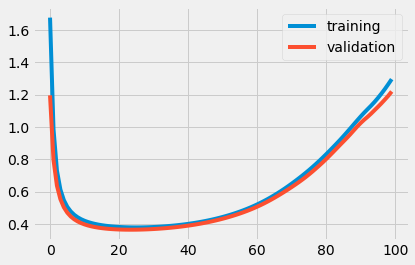

In [176]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(np.arange(len(cost["training"])), cost["training"], label="training")
plt.plot(np.arange(len(cost["validation"])), cost["validation"], label="validation")
plt.legend();

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における 
σ
 は次の式で求められます。

「Xavierの初期値」

## 【問題7】最適化手法
コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。